# AMSC698K Homework 7
##### Elijah Kin & Noorain Noorani

In [ ]:
import numpy as np
import os
import sys

from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
#later: qiskit_nature.settings.use_pauli_sum_op = False
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt

# list of supported optimizers ...
import qiskit_algorithms
#dir(qiskit_algorithms.optimizers)
from qiskit_algorithms.optimizers import SPSA, SLSQP, COBYLA

## optional suppression of deprecation warnings: often in qiskit 
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=UserWarning)

### Plot the dissociation profile obtained via VQE and exact solver for the H2 and LiH molecules. Suggested distance ranges for H2: 0.25 to 3.0 Å, for LiH: 0.5 to 4.0 Å. 

In [4]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

### H2

In [5]:
def get_H2_qubit_operator(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule)
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True,remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [6]:
distances = np.arange(0.25, 3.0, 0.25)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_H2_qubit_operator( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.25 VQE Result: 2.02270 Exact Energy: -0.31227
Interatomic Distance: 0.5 VQE Result: -0.07467 Exact Energy: -1.05516
Interatomic Distance: 0.75 VQE Result: -1.09241 Exact Energy: -1.13712
Interatomic Distance: 1.0 VQE Result: -0.54909 Exact Energy: -1.10115
Interatomic Distance: 1.25 VQE Result: -0.46967 Exact Energy: -1.04578
Interatomic Distance: 1.5 VQE Result: -0.61288 Exact Energy: -0.99815
Interatomic Distance: 1.75 VQE Result: -0.73567 Exact Energy: -0.96633
Interatomic Distance: 2.0 VQE Result: -0.64762 Exact Energy: -0.94864
Interatomic Distance: 2.25 VQE Result: -0.49171 Exact Energy: -0.93998
Interatomic Distance: 2.5 VQE Result: -0.63708 Exact Energy: -0.93605
Interatomic Distance: 2.75 VQE Result: -0.84372 Exact Energy: -0.93435


array([ 5804.71737702, -7105.04645959, -8752.35017424])

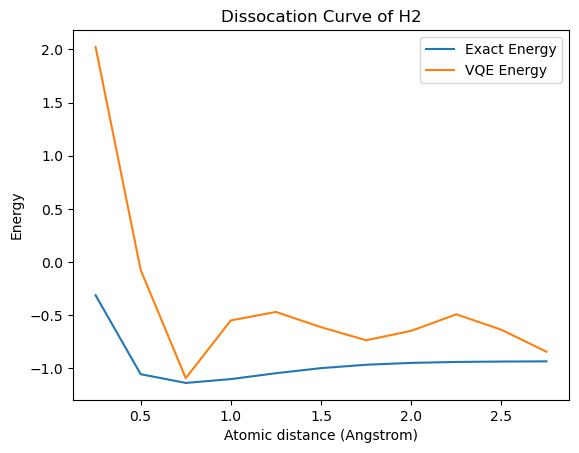

In [7]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of H2")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

#### LiH

In [ ]:
def get_LiH_qubit_operator(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule)
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True,remove_orbitals=[-3, -2]
        # freeze_core=True,remove_orbitals=[0, -1, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [ ]:
distances = np.arange(0.5, 4.0, 0.5)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_LiH_qubit_operator( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.5 VQE Result: -6.62995 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -6.92664 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -6.97791 Exact Energy: -7.72283


KeyboardInterrupt: 

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of LiH")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

### Obtain similar plots (energy vs. interatomic distance) for the s-orbitals considered in the STO-3G setting (1s-1s, 2s-2s).

In [24]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import QubitMapper
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE

In [60]:
def get_H2_qubit_operator_sto3g(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [61]:
distances = np.arange(0.25, 3.0, 0.25)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_H2_qubit_operator_sto3g( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.25 VQE Result: 0.92338 Exact Energy: -0.31227
Interatomic Distance: 0.5 VQE Result: 0.35595 Exact Energy: -1.05516
Interatomic Distance: 0.75 VQE Result: -0.57353 Exact Energy: -1.13712
Interatomic Distance: 1.0 VQE Result: 0.01205 Exact Energy: -1.10115
Interatomic Distance: 1.25 VQE Result: -0.57153 Exact Energy: -1.04578
Interatomic Distance: 1.5 VQE Result: -0.61719 Exact Energy: -0.99815
Interatomic Distance: 1.75 VQE Result: -0.67592 Exact Energy: -0.96633
Interatomic Distance: 2.0 VQE Result: -0.57012 Exact Energy: -0.94864
Interatomic Distance: 2.25 VQE Result: -0.40299 Exact Energy: -0.93998
Interatomic Distance: 2.5 VQE Result: -0.83389 Exact Energy: -0.93605
Interatomic Distance: 2.75 VQE Result: -0.84920 Exact Energy: -0.93435


array([  799.31139039, -3720.62286193,  1509.02344259])

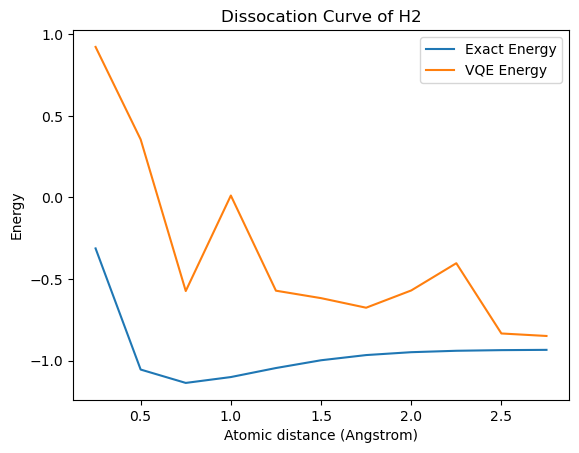

In [62]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of H2")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [63]:
def get_LiH_qubit_operator_sto3g(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2, active_orbitals=[1,2]).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [64]:
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_LiH_qubit_operator_sto3g( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.5 VQE Result: -6.94441 Exact Energy: -7.02905
Interatomic Distance: 0.7 VQE Result: -7.39813 Exact Energy: -7.48612
Interatomic Distance: 0.9 VQE Result: -7.44986 Exact Energy: -7.70589
Interatomic Distance: 1.1 VQE Result: -7.71870 Exact Energy: -7.80888
Interatomic Distance: 1.3 VQE Result: -7.46425 Exact Energy: -7.85212
Interatomic Distance: 1.5 VQE Result: -7.72036 Exact Energy: -7.86358
Interatomic Distance: 1.7 VQE Result: -7.64418 Exact Energy: -7.85746
Interatomic Distance: 1.9 VQE Result: -7.64759 Exact Energy: -7.84161
Interatomic Distance: 2.1 VQE Result: -7.68526 Exact Energy: -7.82058
Interatomic Distance: 2.3 VQE Result: -7.69472 Exact Energy: -7.79723
Interatomic Distance: 2.5 VQE Result: -7.52085 Exact Energy: -7.77354
Interatomic Distance: 2.7 VQE Result: -7.51848 Exact Energy: -7.75142
Interatomic Distance: 2.9 VQE Result: -7.50490 Exact Energy: -7.73322
Interatomic Distance: 3.1 VQE Result: -7.57995 Exact Energy: -7.72155
Interatomic Distance

array([ 5379.93220097, -4034.27628127, -3514.15378179])

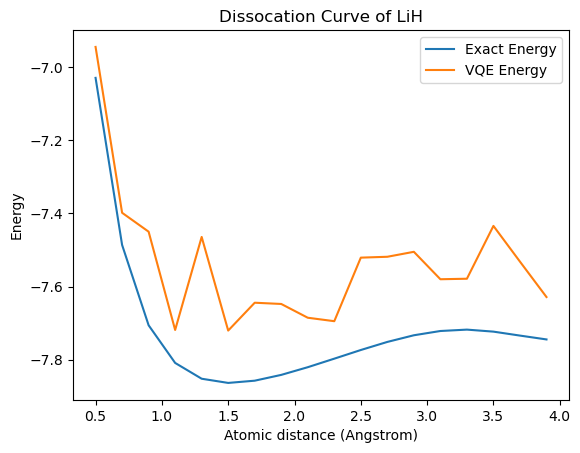

In [65]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of LiH")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

#### Obtain these plots also for all σ bonds considered in the STO-3G setting (1s-1s, 2s-2s, 2s-2pz, 2pz-2pz).

In [72]:
def get_LiH_qubit_operator_sto3g_bonus(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=4).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [73]:
distances = np.arange(0.25, 3.0, 0.25)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_LiH_qubit_operator_sto3g_bonus( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.25 VQE Result: -5.02991 Exact Energy: -5.18444
Interatomic Distance: 0.5 VQE Result: -6.80256 Exact Energy: -7.03829
Interatomic Distance: 0.75 VQE Result: -6.99645 Exact Energy: -7.56004


KeyboardInterrupt: 

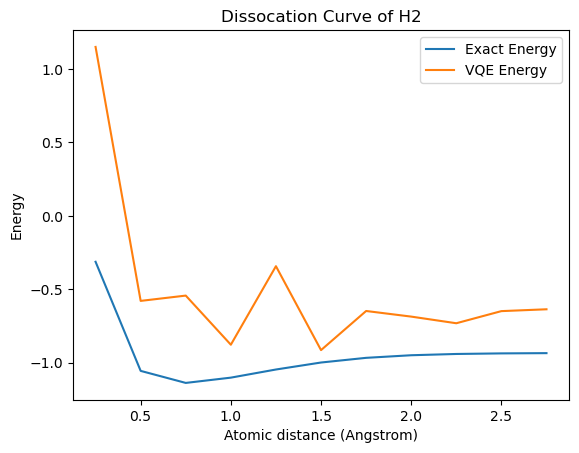

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of H2")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()